# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Загрузка библиотек

In [1]:
import pandas as pd
import random
import numpy as np
from scipy.sparse import coo_matrix, hstack
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, recall_score, precision_score, log_loss, make_scorer

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

seed = 1903
first_categorial_index = 190

Объявим функции, необходимые для построения базовой модели

In [2]:
def fill_numericna(train_frame, test_frame, averageCalculator):
    """ Функция заполняет значения в числовом фрейме значениями, посчитанными averageCalculator. """
    
    # Посчитаем средние по колонкам
    numeric_avgs = averageCalculator(train_frame)
    
    # Оставим только те колонки, в которых среднее значение не равно NaN, т.к. в таких колонках совсем нет значений
    numeric_avgs = numeric_avgs.dropna()
    dropped_columns = train_frame.columns.drop(numeric_avgs.index)
    n_frame_train = train_frame[list(numeric_avgs.index)]
    n_frame_test = test_frame[list(numeric_avgs.index)]
    
    # Заполним пропущенные численные значения средними
    n_frame_train = n_frame_train.fillna(numeric_avgs, axis=0)
    n_frame_test = n_frame_test.fillna(numeric_avgs, axis=0)
    return (n_frame_train, n_frame_test, dropped_columns)

def fill_numericna_means(train_frame, test_frame):
    """ Функция заполняет значения в числовом фрейме средними и удаляет те колонки, в которых значений нет. """
    return fill_numericna(
        train_frame,
        test_frame,
        lambda f: f.mean(axis=0, skipna=True))

def fill_categorial_nav(train_frame, test_frame):
    return train_frame.fillna("NaV"), test_frame.fillna("NaV")

def remove_constant_features(frame, min_count=2):
    """Функция удаляет колонки, которые содержат только одно значение."""
    
    # Посчитаем количества уникальных значений по колонкам
    unique_counts = frame.nunique()
    # Удалим колонки с количеством значений меньшим min_count
    columns_to_drop = unique_counts[unique_counts < min_count].index
    
    return (frame.drop(columns=columns_to_drop), columns_to_drop)

class MatrixLabelEncoder:
    """ Класс кодирует категории числами от 0 до n, где n количество категорий в колонке. """
    
    def __init__(self):
        self.encoders = []
    
    def fit(self, matrix):
        for column_number in range(matrix.shape[1]):
            column = matrix[:,column_number]
            labelEncoder = LabelEncoder().fit(column)
            self.encoders.append(labelEncoder)
        return self
    
    def transform(self, matrix):
        transformed = np.empty(matrix.shape)
        for column_number in range(matrix.shape[1]):
            labelEncoder = self.encoders[column_number]
            num_column = labelEncoder.transform(matrix[:,column_number])
            for row_number, val in enumerate(num_column):
                transformed[row_number, column_number] = val
        return transformed
    
class CompositeEncoder:
    """ Класс принимает набор фабрик с методами fit и transform и последовательно применяет их """
    def __init__(self, encoder_factories):
        self.encoder_factories = encoder_factories
        
    def fit(self, matrix):
        encoders = []
        transformed = matrix
        for encoder_factory in self.encoder_factories:
            encoder = encoder_factory().fit(transformed)
            encoders.append(encoder)
            transformed = encoder.transform(transformed)
        self.encoders = encoders
        return self

    def transform(self, matrix):
        for encoder in self.encoders:
            matrix = encoder.transform(matrix)
        return matrix
    
def predict_ridge_proba(X, model):
    """ Функция возвращает вероятности предсказаний для класса churn модель Ridge """
    # Поскольку RidgeClassifier не обладает функцией predict_proba приходится считать его вручную
    # Подробнее можно посмотреть здесь:
    # https://www.codesd.com/item/scikit-learn-ridge-classifier-extract-class-probabilities.html
    func = model.decision_function(X)
    return np.exp(func) / (1 + np.exp(func))

def predict_model_proba(X, model):
    """ Функция возвращает вероятности предсказаний для класса churn """
    return list(zip(*model.predict_proba(X)))[1]
    
def stratifiedKFold_fscore(
    frame,
    labels,
    model_factory,
    process_frame,
    frame_to_matrix,
    numeric_features,
    categorial_features,
    predict_probabilities,
    seed,
    folds_count = 3):
    """ Функция разбивает набор данных на folds_count, считает ROC-AUC на каждом фолде
        и возвращает усредненное по фолдам значение.
        Функция также возвращает модель, показавшую лучшее качество, её метрики и разделение данных.
        Разделение данных нужно для того, чтобы строить метрики модели на данных, на которых она не обучалась."""
    skf = StratifiedKFold(n_splits=folds_count, shuffle=True, random_state=seed)
    
    best_model = None
    best_score = 0
    best_precision = 0
    best_recall = 0
    best_table = None
    best_split = None
    best_encoders = None
    best_dropped_columns = None
    metrics_sum = 0
    for train_indices, test_indices in skf.split(frame, labels):
        # Разобьем фрем на train и test с помощью функции process_frame
        # Внутри такой функции мы можем по-разному обрабатывать признаки обучаясь только на train наборе.
        train_frame, train_labels, test_frame, test_labels, dropped_numeric, dropped_categorial = process_frame(
            frame.loc[train_indices, :],
            labels.loc[train_indices, :],
            frame.loc[test_indices, :],
            labels.loc[test_indices, :],
            numeric_features,
            categorial_features)
        numeric_cleaned = numeric_features.drop(dropped_numeric)
        categorial_cleaned = categorial_features.drop(dropped_categorial)
        # Преобразуем фреймы в матрицы.
        # Тут можно выполнить финальное преобразование признаков, например масштабирование признаков.
        # В функции frame_to_matrix энкодеры типа StandardScaler обучаются только на train признаках.
        X_train, X_test, y_train, y_test, num_encoder, cat_encoder = frame_to_matrix(
            train_frame,
            test_frame,
            train_labels,
            test_labels,
            numeric_cleaned,
            categorial_cleaned)

        model = model_factory()
        # Обучим модель
        model.fit(X_train, y_train)
        
        # Построим вероятности принадлежности к целевому классу
        probabilities = predict_probabilities(X_test, model)
        # Считаем roc auc score
        rocAuc = roc_auc_score(y_test, probabilities)
        metrics_sum += rocAuc
        if(best_model is None or best_score < rocAuc):
            # В случае, если модель лучше предыдущих сохраним её
            # оценку, модель, матрицу ошибок и разделение данных
            best_score = rocAuc
            best_model = model
            best_dropped_columns = (dropped_numeric, dropped_categorial)
            best_encoders = (num_encoder, cat_encoder)
            best_split = (train_frame, train_labels, test_frame, test_labels)
    return (
        metrics_sum/folds_count,
        best_model,
        best_score,
        best_split,
        best_encoders,
        best_dropped_columns)

def cleanup_frame_common(frame, numeric_features, categorial_features):
    """Функция делит признакина числовые и категориальные и удаляет константные признаки, содержащие только одно значение"""
    # Разделим коллекции на группы - числовые и категориальные.
    numeric_frame = frame[numeric_features].copy()
    categorial_frame = frame[categorial_features].copy()
    # Удалим вещественные колонки, содержащие одно и менее значений. 0 значений мы получаем, когда значения во всех строках Nan.
    numeric_frame_no_const, dropped_const_numeric_columns = remove_constant_features(numeric_frame)
    
    # Удалим категориальные колонки, содержащие ноль значений. Если есть одно значение, то могут быть Nan, которые для
    # категориальных признаков могут быть еще одной категорией (зависит от стратегии обработки).
    categorial_frame_no_const, dropped_const_categorial_columns = remove_constant_features(categorial_frame, 1)
    
    # Восстановим фрейм и вернем вместе с ним список удаленных категориальных колонок.
    return (pd.concat([numeric_frame, categorial_frame], axis=1),
            list(dropped_const_numeric_columns),
            list(dropped_const_categorial_columns))

def process_frame(
    train_frame,
    train_labels,
    test_frame,
    test_labels,
    numeric_features,
    categorial_features,
    fill_na_numerics,
    fill_na_categorial):
    """ Функция обрабатывает числовые признаки, заполняя пропуски. """
    
    # Удалим константные колонки из train_frame, и такие-же колонки из test_frame
    train_frame, const_numeric_columns, const_categorial_columns = cleanup_frame_common(
        train_frame,
        numeric_features,
        categorial_features)
    test_frame = test_frame.drop(columns=const_numeric_columns)
    test_frame = test_frame.drop(columns=const_categorial_columns)
    
    numeric_features = numeric_features.drop(const_numeric_columns)
    categorial_features = categorial_features.drop(const_categorial_columns)
    
    # Заполним пропущенные вещественные значения
    numeric_train, numeric_test, dropped_numeric = fill_na_numerics(
        train_frame[numeric_features],
        test_frame[numeric_features])
    
    numeric_features = numeric_features.drop(dropped_numeric)
    
    # Заполним пропущенные категориальные значения строками "NaV" (Not a value)
    categorial_train, categorial_test = fill_na_categorial(train_frame[categorial_features], test_frame[categorial_features])
    
    # Удалим категориальные колонки с одним единственным значением
    categorial_train, dropped_categorial = remove_constant_features(categorial_train)
    categorial_test = categorial_test.drop(columns=dropped_categorial)
    
    categorial_features = categorial_features.drop(dropped_categorial)
    
    # Список удаленных колонок
    dropped_numeric = np.concatenate([
        list(const_numeric_columns),
        list(dropped_numeric)])
    dropped_categorial = np.concatenate([
        list(const_categorial_columns),
        list(dropped_categorial)])
    
    return (pd.concat([numeric_train, categorial_train], axis=1),
            train_labels,
            pd.concat([numeric_test, categorial_test], axis=1),
            test_labels,
            dropped_numeric,
            dropped_categorial)

def process_frame_base(
    train_frame,
    train_labels,
    test_frame,
    test_labels,
    numeric_features,
    categorial_features):
    return process_frame(
        train_frame,
        train_labels,
        test_frame,
        test_labels,
        numeric_features,
        categorial_features,
        fill_numericna_means,
        fill_categorial_nav)

def scale_features(train_frame, test_frame):
    train_numeric = train_frame.as_matrix()
    
    scaler = StandardScaler().fit(train_numeric)
    
    train_numeric = coo_matrix(scaler.transform(train_numeric))
    test_numeric = coo_matrix(scaler.transform(test_frame.as_matrix()))
    
    return (train_numeric, test_numeric, scaler)

def one_hot_features(train_frame, test_frame):
    fit_matrix = pd.concat([train_frame, test_frame]).as_matrix()
    
    if fit_matrix.shape[0] == 0 or fit_matrix.shape[1] == 0:
        return (coo_matrix(train_frame.as_matrix()), coo_matrix(test_frame.as_matrix()), None)
    categorial_encoder = CompositeEncoder([MatrixLabelEncoder, OneHotEncoder]).fit(fit_matrix)
    
    train_categorial = categorial_encoder.transform(train_frame.as_matrix())
    test_categorial = categorial_encoder.transform(test_frame.as_matrix())
    
    return (train_categorial, test_categorial, categorial_encoder)

def int_label_features(train_frame, test_frame):
    fit_matrix = pd.concat([train_frame, test_frame]).as_matrix()
    categorial_encoder = MatrixLabelEncoder().fit(fit_matrix)
    
    train_categorial = categorial_encoder.transform(train_frame.as_matrix())
    test_categorial = categorial_encoder.transform(test_frame.as_matrix())
    
    return (train_categorial, test_categorial, categorial_encoder)

def frame_to_matrix_one_hot(
    train_frame,
    test_frame,
    train_labels,
    test_labels,
    numeric_features,
    categorial_features):
    """ Функци преобразует фрейм к sparse матрице.
        Масштабирует вещественные признаки и кодирует категориальные с помощью OneHotEncoding. """
    # Масштабируем вещественные признаки
    train_numeric, test_numeric, scaler = scale_features(
        train_frame[numeric_features],
        test_frame[numeric_features])
    
    # Закодируем категориальные признаки значениями от 0 до n с помощью MatrixLabelEncoder
    # One hot encode для категориальных признаков
    train_categorial, test_categorial, categorial_encoder = one_hot_features(
        train_frame[categorial_features],
        test_frame[categorial_features])
    
    y_train = train_labels.as_matrix().flatten()
    y_test = test_labels.as_matrix().flatten()
    
    return (hstack([train_numeric, train_categorial]),
            hstack([test_numeric, test_categorial]),
            y_train,
            y_test,
            scaler,
            categorial_encoder)

def frame_to_matrix_labeled(
    train_frame,
    test_frame,
    train_labels,
    test_labels,
    numeric_features,
    categorial_features):
    """ Функция преобразует фрейм к sparse матрице.
        Масштабирует вещественные признаки и кодирует категориальные целыми числами. """
    
    # Масштабируем вещественные признаки
    train_numeric, test_numeric, scaler = scale_features(
        train_frame[numeric_features],
        test_frame[numeric_features])
    
    # Закодируем категориальные признаки значениями от 0 до n с помощью MatrixLabelEncoder
    train_categorial, test_categorial, categorial_encoder = int_label_features(
        train_frame[categorial_features],
        test_frame[categorial_features])
    
    y_train = train_labels.as_matrix().flatten()
    y_test = test_labels.as_matrix().flatten()
    
    return (hstack([train_numeric, train_categorial]),
            hstack([test_numeric, test_categorial]),
            y_train,
            y_test,
            scaler,
            categorial_encoder)

def ridge_baseline_builder(frame, labels, numeric_features, categorial_features):
    return stratifiedKFold_fscore(
        frame,
        labels,
        RidgeClassifier,
        process_frame_base,
        frame_to_matrix_one_hot,
        numeric_features,
        categorial_features,
        predict_ridge_proba,
        seed)

def random_forest_baseline_builder(frame, labels, numeric_features, categorial_features):
    return stratifiedKFold_fscore(
        frame,
        labels,
        RandomForestClassifier,
        process_frame_base,
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

def gradient_boosting_baseline_builder(frame, labels, numeric_features, categorial_features):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        process_frame_base,
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

Загрузим train dataset.

In [3]:
churn_data_frame = pd.read_csv("..\..\Data\churn_data_train.csv", ",", dtype= { "Var73": np.float64 })
churn_labels_frame = pd.read_csv("..\..\Data\churn_labels_train.csv", dtype= { "labels": np.int64 })
print(churn_data_frame.shape)
print(churn_labels_frame.shape)

(27999, 230)
(27999, 1)


Выделим числовые и категориальные признаки.

In [4]:
numeric_columns = churn_data_frame.columns[:first_categorial_index]
categorial_columns = churn_data_frame.columns[first_categorial_index:]

Базовые модели

In [5]:
ridge_base = ridge_baseline_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)
random_forest_base = random_forest_baseline_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)
gradient_boosting_base = gradient_boosting_baseline_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)

На 2-й неделе я выбрал в качестве основной метрики F-Score, после 4-й неделе я решил изменить метрику. В качестве основной метрики я буду использовать ROC-AUC. Причина проста. Я максимизирую площадь под ROC кривой, а потом с помощью того-же F-Score могу подобрать оптимальный порог, чтобы максимизировать качество предсказаний.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [5]:
def shuffle_frame(frame, labels):
    """ Функция перемешивает фрейм """
    y_name = "labels"
    frame[y_name] = labels[y_name]
    frame = frame.sample(frac=1).reset_index(drop=True)
    labels = pd.DataFrame(frame[y_name], columns=[y_name])
    frame = frame.drop(columns=[y_name])
    return frame, labels

def half_frame(frame, labels):
    """ Функция разделяет фрейм на два пополам """
    half_index = int(frame.shape[0]/2)
    first_half = frame.loc[:half_index, :].reset_index(drop=True)
    first_half_labels = labels.loc[:half_index, :].reset_index(drop=True)
    second_half = frame.loc[half_index+1:, :].reset_index(drop=True)
    second_half_labels = labels.loc[half_index+1:, :].reset_index(drop=True)
    
    first_half, first_half_labels = shuffle_frame(first_half, first_half_labels)
    second_half, second_half_labels = shuffle_frame(second_half, second_half_labels)
    return (first_half, first_half_labels, second_half, second_half_labels)

def find_best_frame_size(
    pinned_data,
    data,
    best_metric,
    best_size,
    round_size=5):
    """ Функция находит размер фрейма, дающий наилучшее качество. """
    step_metric = best_metric
    step_frame, step_labels = data
    left_frame = None
    better_metric = best_metric
    better_size = best_size
    
    while step_metric >= best_metric:
        step_frame, step_labels, left_frame, left_labels = half_frame(step_frame, step_labels)
        
        pinned_frame,pinned_labels = pinned_data
        step_frame = pd.concat([pinned_frame, step_frame], axis=0, ignore_index=True)
        step_labels = pd.concat([pinned_labels, step_labels], axis=0, ignore_index=True).astype(np.int64)
        step_model = gradient_boosting_baseline_builder(
            step_frame,
            step_labels,
            numeric_columns,
            categorial_columns)
        step_metric = np.round(step_model[0], round_size)
        if(step_metric >= better_metric):
            better_metric = step_metric
            better_size = step_frame.shape
        print ("Frame_size %i: %.5f\tInitial quality: %.5f\tLeft_size: %i" % (step_frame.shape[0], step_metric, best_metric, left_frame.shape[0]))
    
    if(left_frame.shape[0] < 14):
        return (better_metric, better_size)
    else:
        return find_best_frame_size(
            (step_frame, step_labels),
            (left_frame, left_labels),
            better_metric,
            better_size)

In [28]:
find_best_frame_size(
    (pd.DataFrame([], columns=churn_data_frame.columns), pd.DataFrame([], columns=churn_labels_frame.columns)),
    (churn_data_frame, churn_labels_frame),
    np.round(gradient_boosting_base[0], 5),
    churn_data_frame.shape)

Frame_size 14000: 0.69898	Initial quality: 0.73199	Left_size: 13999
Frame_size 21000: 0.71753	Initial quality: 0.73199	Left_size: 6999
Frame_size 24500: 0.72973	Initial quality: 0.73199	Left_size: 3499
Frame_size 26250: 0.72812	Initial quality: 0.73199	Left_size: 1749
Frame_size 27125: 0.73019	Initial quality: 0.73199	Left_size: 874
Frame_size 27563: 0.72796	Initial quality: 0.73199	Left_size: 436
Frame_size 27782: 0.72974	Initial quality: 0.73199	Left_size: 217
Frame_size 27891: 0.72876	Initial quality: 0.73199	Left_size: 108
Frame_size 27946: 0.73180	Initial quality: 0.73199	Left_size: 53
Frame_size 27973: 0.72954	Initial quality: 0.73199	Left_size: 26
Frame_size 27987: 0.72853	Initial quality: 0.73199	Left_size: 12


(0.73199000000000003, (27999, 230))

In [7]:
from sklearn.model_selection import learning_curve

# Удалим константные колонки
curve_frame, const_numeric_columns, const_categorial_columns = cleanup_frame_common(
    churn_data_frame,
    numeric_columns,
    categorial_columns)

curve_num_features = numeric_columns.drop(const_numeric_columns)
curve_cat_features = categorial_columns.drop(const_categorial_columns)

# Посчитаем средние по колонкам
numeric_curve_frame = curve_frame[curve_num_features]
numeric_avgs = numeric_curve_frame.mean(axis=0, skipna=True)

# Оставим только те колонки, в которых среднее значение не равно NaN, т.к. в таких колонках совсем нет значений
numeric_avgs = numeric_avgs.dropna()
dropped_numeric = numeric_curve_frame.columns.drop(numeric_avgs.index)
numeric_curve_frame = numeric_curve_frame[list(numeric_avgs.index)]

# Заполним пропущенные численные значения средними
numeric_curve_frame = numeric_curve_frame.fillna(numeric_avgs, axis=0)
curve_num_features = curve_num_features.drop(dropped_numeric)

# Заполним пропущенные категориальные значения строками "NaV" (Not a value)
cat_curve_frame = curve_frame[curve_cat_features].fillna("NaV")

# Удалим категориальные колонки с одним единственным значением
cat_curve_frame, dropped_categorial = remove_constant_features(cat_curve_frame)
curve_cat_features = curve_cat_features.drop(dropped_categorial)

curve_cleaned_frame = pd.concat([numeric_curve_frame, cat_curve_frame], axis=1)

# Масштабируем вещественные признаки
scaler = StandardScaler().fit(numeric_curve_frame)
curve_num_matrix = coo_matrix(scaler.transform(numeric_curve_frame))

# Закодируем категориальные признаки значениями от 0 до n с помощью MatrixLabelEncoder
categorial_encoder = MatrixLabelEncoder().fit(cat_curve_frame.as_matrix())
curve_cat_matrix = categorial_encoder.transform(cat_curve_frame.as_matrix())

curve_x = hstack([curve_num_matrix, curve_cat_matrix])
curve_y = churn_labels_frame.as_matrix().flatten()

item_counts, train_scores, test_scores = learning_curve(
    GradientBoostingClassifier(),
    curve_x,
    curve_y,
    scoring=lambda e, x, y: roc_auc_score(y, list(zip(*e.predict_proba(x)))[1]),
    shuffle=True,
    train_sizes=[0.2,0.4,0.6,0.8,1],
    random_state=seed)

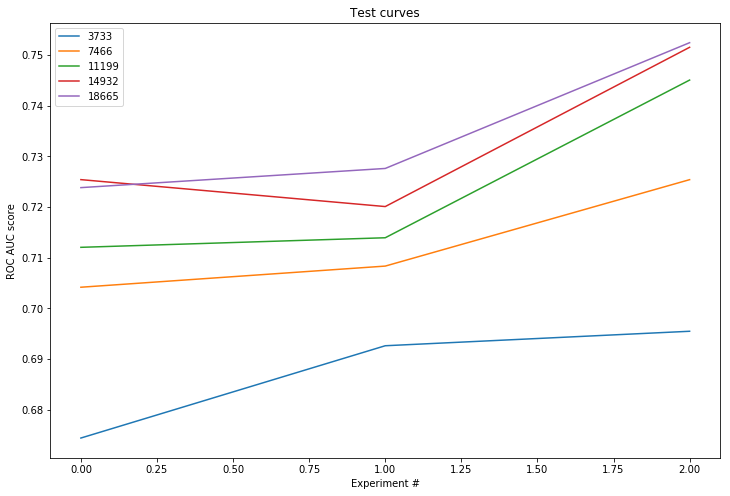

In [9]:
figure = plt.figure(figsize=(12,8))
for idx, count in enumerate(item_counts):
        train_score_curve = train_scores[idx]
        test_score_curve = test_scores[idx]
        plt.plot(
            test_score_curve,
            label=count)
plt.legend()
plt.ylabel("ROC AUC score")
plt.xlabel("Experiment #")
plt.title("Test curves")
plt.show()

По графикам видно, что если выбросить из выборки 20% сэмплов, то качество понижается несущественно. Однако если выбросить больше, то качество уже заметно снижается. На мой взгляд не получится существенно снизить скорость обучения модели за счет уменьшения количества сэмплов.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [6]:
class Weighted_Gradient_Boosting:
    """ Класс-обертка для GradientBoostingClassifier. Задает веса классов в конструкторе, а не методе fit. 
        В методе fit преобразует веса классов в веса сэмплов, так как этого требует GradientBoostingClassifier."""
    def __init__(self, class_weights=None):
        self.class_weights = class_weights
        self.model = GradientBoostingClassifier()
        
    def fit(self, X, y):
        sample_weight = None
        if not(self.class_weights is None):
            sample_weight = []
            for class_value in y:
                weight = self.class_weights[class_value]
                sample_weight.append(weight)
        self.model = self.model.fit(X, y, sample_weight)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
def gradient_boosting_weighted_builder(frame, labels, numeric_features, categorial_features, class_weights=None):
    return stratifiedKFold_fscore(
        frame,
        labels,
        lambda: Weighted_Gradient_Boosting(class_weights),
        lambda tf, tl, tsf, tsl, nf, cf: process_frame(tf, tl, tsf, tsl, nf, cf, fill_numericna_means, fill_categorial_nav),
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

In [82]:
churn_weights = [1, 3, 6, 9, 12]
weighted_models = []

for churn_weight in churn_weights:
    weighted_models.append(gradient_boosting_weighted_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns,
    {-1: 1, 1: churn_weight})[0])

In [83]:
list(zip(churn_weights, weighted_models))

[(1, 0.73240857212958144),
 (3, 0.73181997855368452),
 (6, 0.72725180949066548),
 (9, 0.72651626109880107),
 (12, 0.72191783865633197)]

In [81]:
gb_weights_1_12[0], gb_weights_12_1[0]

(0.72202087916107105, 0.72040660516688082)

Уравновешивание моделей за счет весов не дало прироста качества модели. Даже наоборот качество несколько упало.


2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [7]:
def undersample(frame, labels, classes, take_items_count, seed, balance=1, y_name="labels"):
    min_class = None
    min_size = labels.shape[0]
    selected_items = {}
    for frame_class in classes:
        class_only_labels = labels[labels[y_name] == frame_class]
        selected_items[frame_class] = class_only_labels
        class_size = class_only_labels.shape[0]
        if class_size < min_size:
            min_size = class_size
            min_class = frame_class
    if min_class is None:
        return frame, labels
    else:
        selection_count = int(min_size*balance)
        undersampled_frame = pd.DataFrame([], columns=frame.columns)
        undersampled_labels = pd.DataFrame([], columns=labels.columns)
        for frame_class in classes:
            class_only_labels = selected_items[frame_class]
            class_indices = list(class_only_labels.index)
            class_only_frame = frame.loc[class_indices,:]
            
            if frame_class != min_class:
                class_only_frame[y_name] = class_only_labels[y_name]
                class_only_frame = take_items_count(
                    class_only_frame.reset_index(drop=True),
                    selection_count,
                    seed)
                
                class_only_labels = pd.DataFrame(class_only_frame[y_name], columns=[y_name])
                class_only_frame = class_only_frame.drop(columns=[y_name])
            undersampled_frame = pd.concat([undersampled_frame, class_only_frame], ignore_index=True)
            undersampled_labels = pd.concat([undersampled_labels, class_only_labels], ignore_index=True).astype(np.int64)
                
        return undersampled_frame, undersampled_labels
    
def take_first_items_count(frame, count, seed):
    return frame.head(count).reset_index(drop=True)

def take_items_random(frame, count, seed):
    np.random.seed(seed=seed)
    rnd_indices = np.random.randint(0, frame.shape[0], size=count)
    return frame.loc[rnd_indices, :].reset_index(drop=True)

In [8]:
def balance_frame_sampling(frame_to_balance, labels, repeat_times):
    """ Функция балансирует соотношения классов сэмплируя класс churn. """
    y_name = "labels"
    churn_only_labels = labels[labels[y_name] == 1]
    churn_indices = list(churn_only_labels.index)
    churn_only_frame = frame_to_balance.loc[churn_indices,:]
    churn_balanced_frame = frame_to_balance.copy()
    churn_balanced_labels = labels.copy()
    for i in range(0, (repeat_times-1)):
        churn_balanced_frame = pd.concat([churn_balanced_frame, churn_only_frame], ignore_index=True)
        churn_balanced_labels = pd.concat([churn_balanced_labels, churn_only_labels], ignore_index=True)
        
    churn_balanced_frame[y_name] = churn_balanced_labels[y_name]
    churn_balanced_frame = churn_balanced_frame.sample(frac=1).reset_index(drop=True)
    
    churn_balanced_labels = pd.DataFrame(churn_balanced_frame[y_name], columns=[y_name]).astype(np.int64)
    churn_balanced_frame = churn_balanced_frame.drop(columns=[y_name])
    
    return (churn_balanced_frame, churn_balanced_labels)

def balance_train_frame(train_frame, train_labels, test_frame, test_labels, numeric_features, categorial_features, repeat_times):
    """ Функция балансирует train frame, после этого обрабатывает признаки с помощью метода
        process_frame_base_model """
    balanced_train, balanced_labels = balance_frame_sampling(train_frame, train_labels, repeat_times)
    return process_frame(
        balanced_train,
        balanced_labels,
        test_frame,
        test_labels,
        numeric_features,
        categorial_features,
        fill_numericna_means,
        fill_categorial_nav)
    
def gb_oversampled_builder(frame, labels, numeric_features, categorial_features, repeat_times):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: balance_train_frame(tf, tl, tsf, tsl, nf, cf, repeat_times),
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

In [9]:
def balance_undersampling(
    train_frame,
    train_labels,
    test_frame,
    test_labels,
    numeric_features,
    categorial_features,
    items_selector,
    balance):
    """ Функция балансирует train frame, после этого обрабатывает признаки с помощью метода process_frame_base_model """
    balanced_train, balanced_labels = undersample(
        train_frame,
        train_labels,
        [-1, 1],
        items_selector,
        seed)

    return process_frame(
        balanced_train,
        balanced_labels,
        test_frame,
        test_labels,
        numeric_features,
        categorial_features,
        fill_numericna_means,
        fill_categorial_nav)

def gb_first_items_undersampled_builder(frame, labels, numeric_features, categorial_features, balance):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: balance_undersampling(tf, tl, tsf, tsl, nf, cf, take_first_items_count, balance),
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

def gb_random_undersampled_builder(frame, labels, numeric_features, categorial_features, balance):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: balance_undersampling(tf, tl, tsf, tsl, nf, cf, take_items_random, balance),
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

def ridge_first_items_undersampled_builder(frame, labels, numeric_features, categorial_features, balance):
    return stratifiedKFold_fscore(
        frame,
        labels,
        RidgeClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: balance_undersampling(tf, tl, tsf, tsl, nf, cf, take_first_items_count, balance),
        frame_to_matrix_one_hot,
        numeric_features,
        categorial_features,
        predict_ridge_proba,
        seed)

In [14]:
undersampling_balances = [1, 2, 3]
gb_undersampled_first_items_models = []
gb_undersampled_random_models = []
ridge_undersampled_first_items_models = []

for balance in undersampling_balances:
    gb_undersampled_first_items_models.append(gb_first_items_undersampled_builder(
        churn_data_frame,
        churn_labels_frame,
        numeric_columns,
        categorial_columns,
        balance))
    gb_undersampled_random_models.append(gb_random_undersampled_builder(
        churn_data_frame,
        churn_labels_frame,
        numeric_columns,
        categorial_columns,
        balance))
    ridge_undersampled_first_items_models.append(ridge_first_items_undersampled_builder(
        churn_data_frame,
        churn_labels_frame,
        numeric_columns,
        categorial_columns,
        balance))

In [120]:
comparison_columns = ["Gradient boosting sequential", "Gradient boosting random", "Ridge sequential"]
comparison_data = []
for idx, balance in enumerate(undersampling_balances):
    comparison_data.append([
        gb_undersampled_first_items_models[idx][0],
        gb_undersampled_random_models[idx][0],
        ridge_undersampled_first_items_models[idx][0]])
print(pd.DataFrame(comparison_data, index=undersampling_balances, columns=comparison_columns))

   Gradient boosting sequential  Gradient boosting random  Ridge sequential
1                      0.712794                  0.714268          0.649256
2                      0.712370                  0.714268          0.649256
3                      0.712370                  0.714268          0.649256


In [174]:
gb_oversampled = gb_oversampled_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns,
    12)

0.72325453536248041

In [175]:
gradient_boosting_base[0], gb_oversampled[0]

(0.73199183318256378, 0.72325453536248041)

Уравновешивание моделей с помощью undersampling и oversampling дало несколько нежиданный результат.
Видно, что при undersampling качество модели падает больше чем на процент. Думаю это может быть связано с тем, что выборка при выбрасывании моделей очень сильно уменьшается (до 2778 сэмплов), из-за чего и страдает качество.

При oversampling качество тоже несколько снижается.

В принципе, если понижение качества на один процент не играет роли, то можно уменьшить время обучения модели за счет undersampling.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [10]:
def fill_numericna_medians(train_frame, test_frame):
    """ Функция заполняет значения в числовом фрейме медианами и удаляет те колонки, в которых значений нет. """
    return fill_numericna(
        train_frame,
        test_frame,
        lambda f: f.median(axis=0, skipna=True))

def fill_numericna_modes(train_frame, test_frame):
    """ Функция заполняет значения в числовом фрейме модами и удаляет те колонки, в которых значений нет. """
    return fill_numericna(
        train_frame,
        test_frame,
        lambda f: f.mode(axis=0).iloc[0,:])

def gb_numeric_medians_builder(frame, labels, numeric_features, categorial_features):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: process_frame(tf, tl, tsf, tsl, nf, cf, fill_numericna_medians, fill_categorial_nav),
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

def gb_numeric_modes_builder(frame, labels, numeric_features, categorial_features):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: process_frame(tf, tl, tsf, tsl, nf, cf, fill_numericna_modes, fill_categorial_nav),
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

Заполним пропуски в вещественных признаках медианами и модами и сравним полученное качество с базовой моделью, где пропуски заполнены средними.

In [133]:
gb_numeric_medians = gb_numeric_medians_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)
gb_numeric_modes = gb_numeric_modes_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)
gb_numeric_medians[0], gb_numeric_modes[0], gradient_boosting_base[0]

(0.7234480234826256, 0.72414063842056386, 0.73199183318256378)

За счет изменения стратегии обработки пропусков в вещественных признаках качество повысить не удалось. Заполнение пропусков средними по колонке выглядит оптимальным.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [11]:
def fill_na_frequent_values(train_frame, test_frame):
    """ Функция заполняет пустые значения самым частым значением в колонке. """
    train_result = train_frame.copy()
    test_result = test_frame.copy()
    for column in train_result.columns:
        frequencies = train_result[column].value_counts()
        if (len(frequencies) < 1):
            continue
        most_frequent_value = frequencies.index[0]
        train_result[column] = train_result[column].fillna(most_frequent_value)
        test_result[column] = test_result[column].fillna(most_frequent_value)
    return train_result, test_result

def gb_categorial_frequent_values_builder(frame, labels, numeric_features, categorial_features):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: process_frame(tf, tl, tsf, tsl, nf, cf, fill_numericna_means, fill_na_frequent_values),
        frame_to_matrix_labeled,
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

Заполним пропуски в категориальных признаках самым частым значением признака в колонке

In [138]:
gb_categorial_frequent_values = gb_categorial_frequent_values_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)
gb_categorial_frequent_values[0], gradient_boosting_base[0]

(0.72703473329445079, 0.73199183318256378)

Повысить качество за счет заполнения категориальных признаков частотными значениями не удалось.

In [12]:
def dict_features(train_frame, test_frame):
    fit_matrix = pd.concat([train_frame, test_frame]).T.to_dict().values()
    categorial_encoder = DictVectorizer().fit(fit_matrix)
    
    train_categorial = categorial_encoder.transform(train_frame.T.to_dict().values())
    test_categorial = categorial_encoder.transform(test_frame.T.to_dict().values())
    
    return (train_categorial, test_categorial, categorial_encoder)

def frame_to_matrix_dict(
    train_frame,
    test_frame,
    train_labels,
    test_labels,
    numeric_features,
    categorial_features):
    """ Функци преобразует фрейм к sparse матрице.
        Масштабирует вещественные признаки и кодирует категориальные с помощью OneHotEncoding. """
    
    # Масштабируем вещественные признаки
    train_numeric, test_numeric, scaler = scale_features(
        train_frame[numeric_features],
        test_frame[numeric_features])
    
    # Закодируем категориальные признаки значениями от 0 до n с помощью MatrixLabelEncoder
    # One hot encode для категориальных признаков
    train_categorial, test_categorial, categorial_encoder = dict_features(
        train_frame[categorial_features],
        test_frame[categorial_features])
    
    y_train = train_labels.as_matrix().flatten()
    y_test = test_labels.as_matrix().flatten()
    
    return (hstack([train_numeric, train_categorial]),
            hstack([test_numeric, test_categorial]),
            y_train,
            y_test,
            scaler,
            categorial_encoder)

def ridge_dict_builder(frame, labels, numeric_features, categorial_features):
    return stratifiedKFold_fscore(
        frame,
        labels,
        RidgeClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: process_frame(tf, tl, tsf, tsl, nf, cf, fill_numericna_means, fill_categorial_nav),
        frame_to_matrix_dict,
        numeric_features,
        categorial_features,
        predict_ridge_proba,
        seed)

def gb_dict_builder(frame, labels, numeric_features, categorial_features):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        lambda tf, tl, tsf, tsl, nf, cf: process_frame(tf, tl, tsf, tsl, nf, cf, fill_numericna_means, fill_categorial_nav),
        frame_to_matrix_dict,
        numeric_features,
        categorial_features,
        predict_ridge_proba,
        seed)

Попробуем заменить OneHotEncoder на DictVectorizer и посмотрим как это скажется на качестве. Поскольку OneHotEncoder увеличивает качество линейной модели, то построим с DictVectorizer в т.ч. линейную модель.

In [161]:
ridge_dict = ridge_dict_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)
gb_dict = gb_dict_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)
ridge_base[0], ridge_dict[0], gradient_boosting_base[0], gb_dict[0]

(0.67512496899847863,
 0.57375604497316912,
 0.73199183318256378,
 0.6893237897545238)

Итого я применил следующие алгоритмы обработки категориальных признаков:
    - заполнение пропусков самым частым значением
    - заполнение пропусков новым значением (NaV)
    - преобразование признаков с помощью DictVectorizer
    - преобразование признаков с помощью OneHotEncoder
    - преобразование признаков с помощью LabelEncoder

По результатам видно, что использование DictVectorizer вместо OneHotEncoder для линейной модели уменьшает качество аж на 10%. Использование DictVectorizer вместо LabelEncoder для GradientBoosting понижает качество на 4.2%.

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

На прошлой неделе я использовал алгоритм add-del для отбора признаков. Сравним качество, полученное на признаках, отобранных с помощью этого алгоритма с другими подходами.

In [29]:
add_del_num_features = [
    "Var90", "Var99", "Var110", "Var113", "Var116", "Var126", "Var127",
    "Var140", "Var142", "Var147", "Var157", "Var161", "Var172", "Var186",
    "Var187", "Var189", "Var190", "Var3", "Var4", "Var5", "Var7", "Var13",
    "Var14", "Var16", "Var17", "Var25", "Var28", "Var29", "Var34", "Var49",
    "Var51", "Var53", "Var58", "Var61", "Var73", "Var81", "Var82", "Var83"]
add_del_cat_features = [
    "Var221", "Var229", "Var191", "Var193", "Var194", "Var196", "Var201",
    "Var205", "Var208", "Var211", "Var212", "Var213", "Var215", "Var217",
    "Var218"]
add_del_features = add_del_num_features + add_del_cat_features

gb_add_del = gradient_boosting_baseline_builder(
    churn_data_frame[add_del_features],
    churn_labels_frame,
    pd.Index(add_del_num_features),
    pd.Index(add_del_cat_features))
gb_add_del[0], gradient_boosting_base[0], gb_add_del[2], gradient_boosting_base[2]

(0.73143177904640944,
 0.73234680588912349,
 0.747949546705029,
 0.74273775549762355)

Видно, что среднее качество полученное на алгоритме add-del не повысилось. Зато существенно увеличилась скорость обучения.

Попробуем для отбора признаков SelectKBest из библиотеки sklearn.feature_selection

In [13]:
from sklearn.feature_selection import SelectKBest
def frame_to_matrix_kbest(
    train_frame,
    test_frame,
    train_labels,
    test_labels,
    numeric_features,
    categorial_features,
    k):
    train_matrix, test_matrix, train_labels_mtx, test_labels_mtx, sc, enc = frame_to_matrix_labeled(
        train_frame,
        test_frame,
        train_labels,
        test_labels,
        numeric_features,
        categorial_features)
    selector = SelectKBest(k=k).fit(train_matrix, train_labels_mtx)
    train_matrix = selector.transform(train_matrix)
    test_matrix = selector.transform(test_matrix)
    
    return (train_matrix,
            test_matrix,
            train_labels_mtx,
            test_labels_mtx,
            sc,
            enc)

def gradient_boosting_kbest_builder(frame, labels, numeric_features, categorial_features, k):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        process_frame_base,
        lambda tf, tsf, tl, tsl, nf, cf: frame_to_matrix_kbest(tf, tsf, tl, tsl, nf, cf, k),
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

In [32]:
gb_kbest = gradient_boosting_kbest_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns,
    60)
gb_kbest[0], gradient_boosting_base[0]

(0.73208237572347412, 0.73234680588912349)

Попробуем для отбора признаков SelectFdr из библиотеки sklearn.feature_selection

In [14]:
from sklearn.feature_selection import SelectFdr
def frame_to_matrix_fdr(
    train_frame,
    test_frame,
    train_labels,
    test_labels,
    numeric_features,
    categorial_features,
    alpha):
    train_matrix, test_matrix, train_labels_mtx, test_labels_mtx, sc, enc = frame_to_matrix_labeled(
        train_frame,
        test_frame,
        train_labels,
        test_labels,
        numeric_features,
        categorial_features)
    selector = SelectFdr(alpha=alpha).fit(train_matrix, train_labels_mtx)
    train_matrix = selector.transform(train_matrix)
    test_matrix = selector.transform(test_matrix)
    
    return (train_matrix,
            test_matrix,
            train_labels_mtx,
            test_labels_mtx,
            sc,
            enc)

def gradient_boosting_fdr_builder(frame, labels, numeric_features, categorial_features, alpha=0.05):
    return stratifiedKFold_fscore(
        frame,
        labels,
        GradientBoostingClassifier,
        process_frame_base,
        lambda tf, tsf, tl, tsl, nf, cf: frame_to_matrix_fdr(tf, tsf, tl, tsl, nf, cf, alpha),
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

In [35]:
gb_fdr = gradient_boosting_fdr_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)
gb_fdr[0], gradient_boosting_base[0]

(0.73256213966789918, 0.73234680588912349)

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [40]:
for count in [60, 40, 21]:
    gb_kbest = gradient_boosting_kbest_builder(
        churn_data_frame,
        churn_labels_frame,
        numeric_columns,
        categorial_columns,
        count)
    print(str(count) + " features k-best: ", gb_kbest[0], gradient_boosting_base[0])

60 features k-best:  0.731918842375 0.732346805889
40 features k-best:  0.732501224569 0.732346805889
21 features k-best:  0.735627198952 0.732346805889


Оптимальным количеством фич для алгоритма k-best является 21 (Тут надо признать, что я конечно провел больше 3х экспериментов).

In [42]:
for alpha in [0.01, 0.02, 0.025, 0.03, 0.035]:
    gb_fdr = gradient_boosting_fdr_builder(
        churn_data_frame,
        churn_labels_frame,
        numeric_columns,
        categorial_columns,
        alpha)
    print(str(alpha) + " features FDR: ", gb_fdr[0], gradient_boosting_base[0])

0.01 features FDR:  0.734424444575 0.732346805889
0.02 features FDR:  0.734815478137 0.732346805889
0.025 features FDR:  0.734876244788 0.732346805889
0.03 features FDR:  0.734390064761 0.732346805889
0.035 features FDR:  0.733480041925 0.732346805889


In [15]:
preprocessed_frame, preprocessed_labels, pf, pl, dropped_num_cols, dropped_cat_cols = process_frame_base(
    churn_data_frame,
    churn_labels_frame,
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns)

clear_num_columns = numeric_columns.drop(dropped_num_cols)
clear_cat_columns = categorial_columns.drop(dropped_cat_cols)

preprocessed_x, px, preprocessed_y, py, ne, ce = frame_to_matrix_kbest(
    preprocessed_frame,
    pf,
    preprocessed_labels,
    pl,
    clear_num_columns,
    clear_cat_columns,
    21)

preprocessed_x.shape, preprocessed_y.shape

((27999, 21), (27999,))

In [268]:
from sklearn.model_selection import GridSearchCV
roc_auc_scorer = make_scorer(roc_auc_score)
tune_params = {
    "loss": ["deviance", "exponential"],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [80, 100, 120],
    "max_depth": [2,3,5]
}

estimation_result = GridSearchCV(GradientBoostingClassifier(), tune_params, scoring=roc_auc_scorer).fit(
    preprocessed_x,
    preprocessed_y)
estimation_result.best_estimator_, estimation_result.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.2, loss='deviance', max_depth=5,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=80,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False), 0.51664933925003875)

In [16]:
def gradient_boosting_params_builder(frame, labels, numeric_features, categorial_features, k, params):
    return stratifiedKFold_fscore(
        frame,
        labels,
        lambda: GradientBoostingClassifier(learning_rate=params["learning_rate"], n_estimators=params["n_estimators"], max_depth=params["max_depth"]),
        process_frame_base,
        lambda tf, tsf, tl, tsl, nf, cf: frame_to_matrix_kbest(tf, tsf, tl, tsl, nf, cf, k),
        numeric_features,
        categorial_features,
        predict_model_proba,
        seed)

In [271]:
gb_params_1 = gradient_boosting_params_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns,
    21,
    {
        "learning_rate": 0.2,
        "n_estimators": 80,
        "max_depth": 5
    })
gb_params_1[0], gb_kbest[0], gradient_boosting_base[0]

(0.72013867039234913, 0.73550269049261063, 0.73199183318256378)

In [243]:
tune_params_2 = {
    "loss": ["exponential"],
    "n_estimators": [120, 140, 160, 180],
    "max_depth": [5, 7, 9, 11]
}

estimation_result_2 = GridSearchCV(GradientBoostingClassifier(), tune_params_2).fit(preprocessed_x, preprocessed_y)
estimation_result_2.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=160,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [251]:
gb_params_2 = gradient_boosting_params_builder(
    churn_data_frame,
    churn_labels_frame,
    numeric_columns,
    categorial_columns,
    21,
    {
        "loss": "deviance",
        "n_estimators": 160,
        "max_depth": 5
    })
gb_params_2[0], gb_kbest[0], gradient_boosting_base[0]

(0.73020055429043784, 0.73550269049261063, 0.73199183318256378)

Повысить качество за счет подбора параметров GradientBoostingClassifier не удалось.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [17]:
labeled_x, px, l_y, py, ne, ce = frame_to_matrix_labeled(
    preprocessed_frame,
    pf,
    preprocessed_labels,
    pl,
    clear_num_columns,
    clear_cat_columns)

mdl = SelectKBest(k=labeled_x.shape[1]).fit(labeled_x, preprocessed_y)
list(sorted(zip(preprocessed_frame.columns, mdl.scores_), key=lambda f: -f[1]))[:21]

[('Var189', 168.53999834060247),
 ('Var7', 138.72396029560818),
 ('Var218', 137.2227289436527),
 ('Var73', 133.55011699962719),
 ('Var207', 102.89224301476428),
 ('Var229', 82.801907052937594),
 ('Var113', 81.849727248593794),
 ('Var144', 80.90708401606885),
 ('Var13', 63.811817425539232),
 ('Var126', 54.184525747264786),
 ('Var65', 44.848639710782159),
 ('Var193', 38.408317957057513),
 ('Var211', 31.447816346853354),
 ('Var74', 30.508489203834287),
 ('Var81', 28.423406450109585),
 ('Var205', 27.934883013676473),
 ('Var228', 27.210062827759188),
 ('Var210', 24.40728674047406),
 ('Var72', 21.712533257764612),
 ('Var227', 17.613599825910271),
 ('Var216', 17.597994397105545)]

Алгоритм SelectKBest выбрал 11 наиболее сильно коррелирующих с целевой переменной вещественных признака.
С категориальными признаками все не так однозначно. Алгоритм выбрал 10 из 26 наиболее сильно коррелирующих, но эти 10 не находятся в топе (среди 26 лучших) по корреляции с целевой переменной.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [18]:
best_train_frame, best_train_labels, best_test_frame, best_test_labels = gb_kbest[3]
num_cols_to_drop, cat_cols_to_drop = gb_kbest[5]
num_cleaned = numeric_columns.drop(num_cols_to_drop)
cat_cleaned = categorial_columns.drop(cat_cols_to_drop)

X_train, X_test, y_train, y_test, num_encoder, cat_encoder = frame_to_matrix_kbest(
    best_train_frame,
    best_test_frame,
    best_train_labels,
    best_test_labels,
    num_cleaned,
    cat_cleaned,
    21)
best_model = gb_kbest[1]
# Построим вероятности принадлежности к целевому классу
test_probabilities = predict_model_proba(X_test, best_model)

NameError: name 'gb_kbest' is not defined

In [299]:
labels_list = [0 if l == -1 else 1 for l in best_test_labels.as_matrix().flatten()]
indices_by_error = [v[0] for v in sorted(
    zip(list(best_test_labels.index), labels_list, test_probabilities),
    key=lambda v: -np.abs(v[1]-v[2]))]
churn_data_frame.loc[indices_by_error, list(num_cleaned) + list(cat_cleaned)].head(20)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
17678,NaN,NaN,NaN,NaN,NaN,1001.0,7.0,NaN,NaN,NaN,...,2Wb19U9,oslk,SQ6wBif,LM8l689qOp,NaN,NaN,uWr3,RAYp,55YFVY9,am7c
19991,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,NaN,...,ncuRoKG,oslk,aK_wS9i,NaN,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN
2335,NaN,NaN,NaN,NaN,NaN,448.0,0.0,NaN,NaN,NaN,...,6XEoI0_,oslk,bSgltRa,LM8l689qOp,NaN,NaN,wX53,RAYp,F2FyR07IdsN7I,NaN
6983,NaN,NaN,NaN,NaN,NaN,1771.0,14.0,NaN,NaN,NaN,...,iokpc3q,d0EEeJi,E2dt_DD,LM8l689qOp,NaN,NaN,xb3V,nIGXDli,F2FyR07IdsN7I,NaN
7812,NaN,NaN,NaN,NaN,NaN,882.0,14.0,NaN,NaN,NaN,...,XbZahzR,Al6ZaUT,3W_Cq2T,LM8l689qOp,NaN,ELof,WqMG,02N6s8f,R4y5gQQWY8OodqDV,NaN
592,NaN,NaN,NaN,NaN,NaN,2884.0,7.0,NaN,NaN,NaN,...,s03jbzC,oslk,laR6FsY,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN
2051,NaN,NaN,NaN,NaN,NaN,4018.0,7.0,NaN,NaN,NaN,...,fabLnWA,oslk,EPqQcw6,jySVZNlOJy,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86
22080,NaN,NaN,NaN,NaN,NaN,658.0,0.0,NaN,NaN,NaN,...,zWAdHAC,d0EEeJi,o8HI39x,LM8l689qOp,NaN,NaN,TNEC,nIGXDli,F2FyR07IdsN7I,NaN
27143,NaN,NaN,NaN,NaN,NaN,9835.0,28.0,NaN,NaN,NaN,...,4UxGlow,QKW8DRm,catzS2D,jySVZNlOJy,NaN,kG3k,FSa2,ZI9m,ib5G6X1eUxUn6,am7c
308,NaN,NaN,NaN,NaN,NaN,308.0,0.0,NaN,NaN,NaN,...,8d5YWu3,oslk,sXbT3Cb,LM8l689qOp,NaN,kG3k,WqMG,RAYp,F2FyR07IdsN7I,NaN


Видно, что на объектах, дающих наибольшую ошибку очень мало заполненных числовых признаков.
Также из графиков, построенных на 1й неделе мы знаем, что разделяющая поверхность между классами довольно размыта, что и объясняет наличие объектов с большой ошибкой.
Для улучшения модели можно попробовать отсеивать слабо заполненные объекты (но, как мы помним из кривых обучения не более 20%)

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

В итоге наилучшее качество я получил, построив модель на основе GradientBoostingClassifier.
При предварительном отборе признаков удаляются все константные признаки и признаки не содержащие значений.
Для более точного отбора призков используется алгоритм SelectKBest, выбирающий 21 колонку.
Вещественные признаки масштабируются с помощью StandardScaler.
К категориальным признакам применяется LabelEncoder.

In [19]:
test_data_frame = pd.read_csv("..\..\Data\churn_data_holdout.csv", ",", dtype= { "Var73": np.float64 })
test_labels_frame = pd.read_csv("..\..\Data\churn_labels_holdout.csv", dtype= { "labels": np.int64 })

In [20]:
k_best_21_features = [f[0] for f in sorted(zip(preprocessed_frame.columns, mdl.scores_), key=lambda f: -f[1])][:21]
k_best_21_num = pd.Index(list(set(numeric_columns) & set(k_best_21_features)))
k_best_21_cat = pd.Index(list(set(categorial_columns) & set(k_best_21_features)))
print("Best numeric:", ", ".join(k_best_21_num))
print("Best categorial:", ", ".join(k_best_21_cat))

Best numeric: Var74, Var13, Var126, Var72, Var65, Var81, Var144, Var73, Var113, Var189, Var7
Best categorial: Var227, Var229, Var228, Var218, Var210, Var193, Var205, Var207, Var211, Var216


In [21]:
best_train_frame, best_train_labels, holdout_test_frame, holdout_test_labels, dropped_train_num, dropped_train_cat = process_frame_base(
    churn_data_frame[k_best_21_features],
    churn_labels_frame,
    test_data_frame[k_best_21_features],
    test_labels_frame,
    k_best_21_num,
    k_best_21_cat)

train_num_cols = k_best_21_num.drop(dropped_train_num)
train_cat_cols = k_best_21_cat.drop(dropped_train_cat)

preprocessed_x_train, preprocessed_x_test, preprocessed_y_train, preprocessed_y_test, ne, ce = frame_to_matrix_labeled(
    best_train_frame,
    holdout_test_frame,
    best_train_labels,
    holdout_test_labels,
    train_num_cols,
    train_cat_cols)

preprocessed_x_test.shape, preprocessed_y_test.shape

((12001, 21), (12001,))

In [36]:
def get_model_data(model_with_data, num_cols, cat_cols):
    """ Функция принимает на вход результат stratifiedKFold_fscore и возвращает только модель и её X_test и y_test """
    model = model_with_data[1]
    split = model_with_data[3]
    X_t_f = split[0]
    y_t_f = split[1]
    X_frame = split[2]
    y_frame = split[3]
    X_train, X, y_train, y, num_encoder, cat_encoder = frame_to_matrix_labeled(
            X_t_f,
            X_frame,
            y_t_f,
            y_frame,
            num_cols,
            cat_cols)
    return (model,X,y)

def calculate_metrics(model_with_data, num_cols, cat_cols, predict_probabilities, build_predictions):
    """ Посчитаем метрики качества для модели """
    model, X, y = get_model_data(model_with_data, num_cols, cat_cols)
    probabilities = predict_probabilities(X, model)
    predictions = build_predictions(X, model)
    # Считаем F-меру, precision и recall
    fscore = f1_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    # Считаем Log loss
    logLoss = log_loss(y, probabilities)
    # Считаем roc auc score
    rocAuc = roc_auc_score(y, probabilities)
    return (precision,recall,fscore,logLoss,rocAuc)

In [23]:
bestmodel = GradientBoostingClassifier().fit(preprocessed_x_train, preprocessed_y_train)
train_model = gradient_boosting_baseline_builder(
    churn_data_frame[k_best_21_features],
    churn_labels_frame,
    k_best_21_num,
    k_best_21_cat)
final_test_probabilities = predict_model_proba(preprocessed_x_test, bestmodel)
finalTrainRocAuc = train_model[0]
finalTestRocAuc = roc_auc_score(preprocessed_y_test, final_test_probabilities)
finalTrainRocAuc, finalTestRocAuc

(0.7358439495605924, 0.73861912018455878)

In [37]:
test_model_with_data = (finalTestRocAuc, bestmodel, 0, (best_train_frame, best_train_labels, holdout_test_frame, holdout_test_labels))
score_table = pd.DataFrame(
    [
        calculate_metrics(train_model, train_num_cols, train_cat_cols, predict_model_proba, lambda x, m: m.predict(x)),
        calculate_metrics(test_model_with_data, train_num_cols, train_cat_cols, predict_model_proba, lambda x, m: m.predict(x))
    ],
    index=["Train quality", "Test quality"],
    columns=["Precision", "Recall", "F-Score", "Log Loss", "Roc Auc"])

In [38]:
def transform_to_chart_model(label, model_with_data, num_cols, cat_cols, predict_probabilities):
    """ Функция принимает на вход заголовок, результат функции stratifiedKFold_fscore и функцию, считающую вероятности
    и возвращает заголовок, вектор ответов и вектор вероятностей для построения графиков """
    model, X, y = get_model_data(model_with_data, num_cols, cat_cols)
    probabilities = predict_probabilities(X, model)
    return (label, y, probabilities)

def charts_row(model_charts, chart_builder, figsize=(11, 4)):
    """ Функция принимает данные для построения графиков и логику построения одного графика и строит графики в одну строку """
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(model_charts),
        figsize=figsize,
        sharey=True)
    for i, chart_data in enumerate(model_charts):
        ax = axes[i]
        chart_builder(chart_data, ax, i)
    plt.show()
    
def scatter(chart_data, ax, ax_index, T=0.5):
    """ Функция строит график распределения вероятностей по классам """
    label, actual, predicted = chart_data
    ax.scatter(actual, predicted)
    ax.set_xlabel("Labels")
    if ax_index == 0:
        ax.set_ylabel("Predicted probabilities")
    ax.set_title(label)
    ax.plot([-1.1, 1.2], [T, T])
    ax.axis([-1.1, 1.1, -0.1, 1.1])
    
def precision_recal_thresh(chart_data, ax, ax_index):
    """ Функция строит графики значений precision и recall в зависимости от порога """
    label, actual, predicted = chart_data
    prec, rec, thresh = precision_recall_curve(actual, predicted)
    min_len = min([len(prec),len(rec),len(thresh)])
    ax.plot(thresh[:min_len], prec[:min_len], label="precision")
    ax.plot(thresh[:min_len], rec[:min_len], label="recall")
    ax.legend(loc=1)
    ax.set_xlabel("threshold")
    ax.set_title(label)
    
def auc_prc(chart_data, ax, ax_index):
    """ Функция строит график AUC PRC (зависимость precision от recall)"""
    label, actual, predicted = chart_data
    prec, rec, thresh = precision_recall_curve(actual, predicted)
    min_len = min([len(prec),len(rec),len(thresh)])
    ax.plot(rec[:min_len], prec[:min_len])
    ax.set_xlabel("recall")
    if ax_index == 0:
        ax.set_ylabel("precision")
    ax.set_title(label)

def calc_min_distance (actual,predicted):
    """ Функция считает минимальное расстояние до точки [0;1] для AUC ROC """
    fpr,tpr,thr = roc_curve(actual,predicted)
    distance,fpr_v,tpr_v,thr_v = min(zip(np.sqrt((1.-tpr)**2+fpr**2),fpr,tpr,thr), key=lambda d:d[0])
    return (distance,fpr_v,tpr_v,thr_v)
    
def auc_roc(chart_data, ax, ax_index):
    """ Функция строит кривую AUC ROC и отмечает точку, соответствующую минимальному расстоянию до точки [0;1] """
    label, actual, predicted = chart_data
    fpr, tpr, thr = roc_curve(actual, predicted)
    min_dist,min_fpr,min_tpr,_ = calc_min_distance(actual, predicted)
    ax.plot(fpr, tpr, label="ROC AUC curve")
    ax.scatter(min_fpr,min_tpr,color="red")
    ax.set_xlabel("false positive rate")
    if ax_index == 0:
        ax.set_ylabel("true positive rate")
    ax.legend(loc=4)
    ax.set_title(label)

In [39]:
chart_models = [transform_to_chart_model(t, m, train_num_cols, train_cat_cols, predict_model_proba) for t, m in zip(
    ["Train", "Test"],
    [train_model, test_model_with_data]
)]

In [40]:
score_table

,Precision,Recall,F-Score,Log Loss,Roc Auc
Train quality,0.454545,0.014409,0.027933,0.237044,0.746867
Test quality,0.466667,0.007839,0.015419,0.237020,0.738619


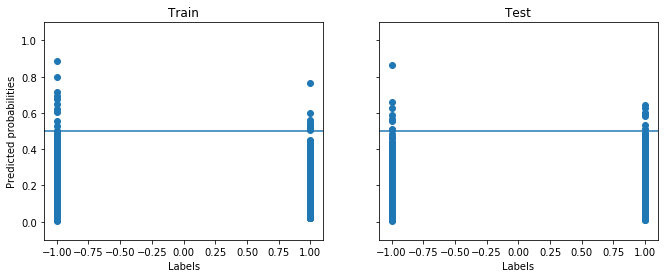

In [28]:
charts_row(chart_models, scatter)

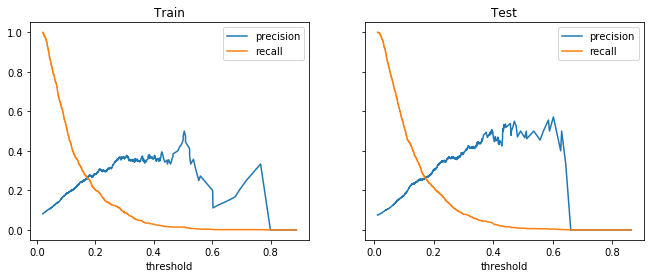

In [29]:
charts_row(chart_models, precision_recal_thresh)

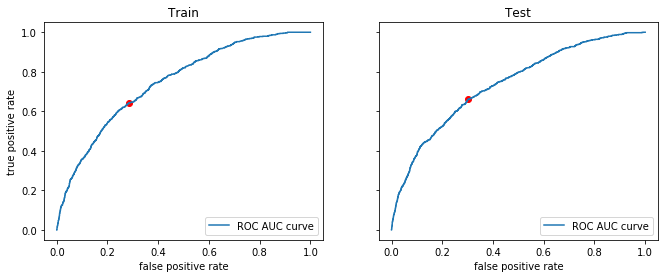

In [30]:
charts_row(chart_models, auc_roc)

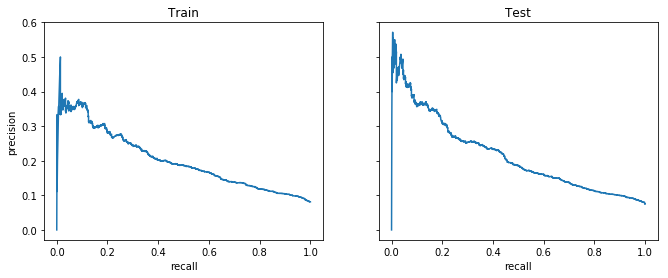

In [31]:
charts_row(chart_models, auc_prc)

In [43]:
def build_predictions(X, model, predict_proba, threshold):
    probabilities = predict_proba(X, model)
    return [-1 if probability < threshold else 1 for probability in probabilities]

In [69]:
best_threshold = 0
best_metrics = None
best_f_score = 0
prev_recall = 0
cur_recall = 0
for threshold in np.arange(0.0, 1.0, 0.01):
    metrics = calculate_metrics(
        test_model_with_data,
        train_num_cols,
        train_cat_cols,
        predict_model_proba,
        lambda x, m: build_predictions(x, m, predict_model_proba, threshold))
    f1score = metrics[2]
    #cur_recall = metrics[1]
    # if(cur_recall < prev_recall and cur_recall < 0.5):
    #    break;
    #else:
    #    prev_recall = cur_recall
    if(f1score > best_f_score):
        best_threshold = threshold
        best_metrics = metrics
        best_f_score = f1score
score_table = pd.DataFrame(
    [
        calculate_metrics(train_model, train_num_cols, train_cat_cols, predict_model_proba, lambda x, m: m.predict(x)),
        calculate_metrics(test_model_with_data, train_num_cols, train_cat_cols, predict_model_proba, lambda x, m: m.predict(x)),
        best_metrics
    ],
    index=["Train quality", "Test quality", "Best threshold"],
    columns=["Precision", "Recall", "F-Score", "Log Loss", "Roc Auc"])
score_table

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Precision,Recall,F-Score,Log Loss,Roc Auc
Train quality,0.454545,0.014409,0.027933,0.237044,0.746867
Test quality,0.466667,0.007839,0.015419,0.237020,0.738619
Best threshold,0.232573,0.399776,0.294069,0.237020,0.738619


In [70]:
best_threshold

0.13

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

- Попробовать еще поподбирать модели (например SVM, LogisticRegression).
- Более скрупулезно подойти к подбору параметров модели и подбирать их по-одному, а не все скопом.
- Отбирать категориальные и вещественные признаки разными алгоритмами.
- Поискать сильно скоррелированные друг с другом признаки и удалить их.
- Попробовать совсем другие способы отбора признаков.